In [69]:
import pandas as pd
import numpy as np
# Function to process CSV files
def process_csv(file_path):
    try:
        df = pd.read_csv(file_path)
        # Perform some processing on the DataFrame
        df.fillna(0, inplace=True)  # Example: Fill NaN values with 0
        return df
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Example usage
input_file_path = "Derivative_Prices.csv"
processed_df = process_csv(input_file_path)
derivative_price = processed_df['Prices'][1:]

In [70]:
import numpy as np
import math
from gbm_func import *
# import importlib
# importlib.reload(gbm)

# Input array of prices and volatilities
derivative_price = processed_df['Prices'][1:]
underlying_price = [11130.44 for i in range(70)] #TODO
volatility = [0.1666 for i in range(70)] #TODO


starting_N = 258
N = len(derivative_price)
dt = 1/252
inital_price = 11130.44
r = 0.01
Nsim = 1000
sigma = 0.136 


In [71]:

def backtest(underlying_price, volatility, Nsim, func):
    price = [0 for i in range(len(derivative_price))]
    for i in range(len(derivative_price)):
        N = starting_N - i
        current_price = underlying_price[i]
        current_volatility = volatility[i]

        sim_prices = func(current_volatility, N, current_price, r = 0.01, Nsim = Nsim)
        payoff_prices = payoff_sim(sim_prices, N, r)
        price[i] = np.mean(payoff_prices)
    return price



In [72]:
print(x:=backtest(underlying_price, volatility, Nsim = 100, func = GBM))

[np.float64(1059.1416662504314), np.float64(1082.5469950410761), np.float64(1071.3274439553952), np.float64(1093.250866680398), np.float64(1071.7300810028712), np.float64(1080.0287383897085), np.float64(1068.1984271279698), np.float64(1086.5601960946638), np.float64(1086.117680484268), np.float64(1071.8393068519863), np.float64(1086.8605824211156), np.float64(1087.5355358864022), np.float64(1101.3520491715326), np.float64(1060.62493061042), np.float64(1074.4764663969147), np.float64(1067.936029613904), np.float64(1070.0043055833878), np.float64(1070.2660927126374), np.float64(1083.2313164582513), np.float64(1077.8657953603654), np.float64(1077.4469138847626), np.float64(1083.4354037529226), np.float64(1066.0601264261436), np.float64(1101.6473683239926), np.float64(1073.714055763222), np.float64(1073.534738354353), np.float64(1096.4624219676368), np.float64(1080.525308362922), np.float64(1070.6154778414218), np.float64(1077.5541019765133), np.float64(1078.6633714598065), np.float64(1072

In [73]:
y  = backtest(underlying_price, volatility, Nsim = 100, func = GBM_AV)

In [74]:
z = backtest(underlying_price, volatility, Nsim = 100, func = gbm_SS)

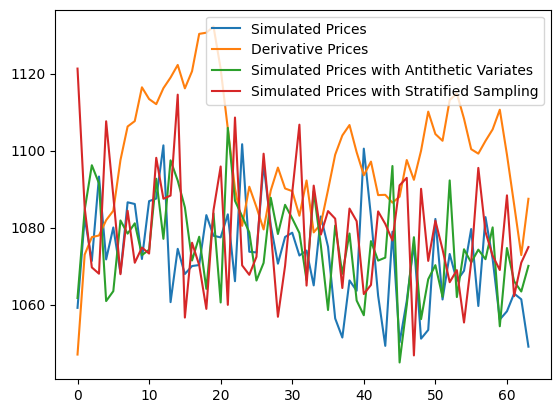

In [75]:
t = np.arange(0, len(derivative_price), 1)
import matplotlib.pyplot as plt
plt.plot(t, x)
plt.plot(t, derivative_price)
plt.plot(t, y)
plt.plot(t, z)
plt.legend(['Simulated Prices', 'Derivative Prices', 'Simulated Prices with Antithetic Variates', 'Simulated Prices with Stratified Sampling'])
plt.show()

In [76]:
def get_delta(sigma, N, S_0,  r = 0.01 , Nsim = 10000, barrier_price = 6566.9596, delta = 0.01):
    # Create a 2D array to store the stock prices for each simulation
    S = np.zeros([Nsim,N])
    S_plus = np.zeros([Nsim,N])
    S_minus = np.zeros([Nsim,N])

    S[:,0] = S_0
    S_plus[:,0] = S_0 * (1 + delta)
    S_minus[:,0] = S_0 * (1 - delta)

    for i in range(Nsim):
        S[i,0]=S_0
        for j in range(N-1):
            Z = np.random.normal(0, 1)
            
            # Calculate the stock price at time t+1 using the Geometric Brownian Motion model with risk-free interet rate
            S[i,j+1] = S[i,j] * np.exp( (r - 0.5 * sigma ** 2) * dt + sigma * Z * np.sqrt(dt) )
            S_plus[i,j+1] = S_plus[i,j] * np.exp( (r - 0.5 * sigma ** 2) * dt + sigma * Z * np.sqrt(dt) )
            S_minus[i,j+1] = S_minus[i,j] * np.exp( (r - 0.5 * sigma ** 2) * dt + sigma * Z * np.sqrt(dt) )

            
    # Calculate the expected final price of the derivative discounted to present value
    exact = payoff_sim(S, N, r=0.01)
    exact_plus = payoff_sim(S_plus, N, r=0.01)
    exact_minus = payoff_sim(S_minus, N, r=0.01)

    plus = np.mean(exact_plus)
    minus = np.mean(exact_minus)
    exact = np.mean(exact)
    # print(f'{plus  = }, {minus = }, {exact = }, Notedelta = {(plus - minus) / (2 * S_0 * delta)}')
    delta = (plus - minus) / (2 * S_0 * delta)
    gamma = (plus - 2 * exact + minus) / (S_0 * delta ** 2)
    return (delta, gamma)

In [77]:
def backtest_delta(underlying_price, volatility, Nsim):
    delta_arr = [0 for i in range(len(derivative_price))]
    gamma_arr = [0 for i in range(len(derivative_price))]
    # price = [0 for i in range(len(derivative_price))]
    for i in range(len(derivative_price)):
        N = starting_N - i
        current_price = underlying_price[i]
        current_volatility = volatility[i]

        delta, gamma = get_delta(current_volatility, N, current_price, r = 0.01, Nsim = Nsim)
        delta_arr[i] = delta
        gamma_arr[i] = gamma
    return delta_arr, gamma_arr


In [ ]:
delta, gamma = backtest_delta(underlying_price, volatility, Nsim = 100)

[np.float64(0.008211767773102539), np.float64(0.0050781386989443246), np.float64(0.05690615983068309), np.float64(0.013358713397272171), np.float64(0.008290903902190875), np.float64(0.007872138578828108), np.float64(-0.0494063623398677), np.float64(0.012207976890882296), np.float64(0.003646602327525187), np.float64(0.012978585132668568), np.float64(0.062491221689271396), np.float64(0.004836134651340133), np.float64(0.00511744306490316), np.float64(0.002647781497865914), np.float64(0.012174612374904702), np.float64(0.007152321258833243), np.float64(0.006580218686006973), np.float64(0.000632305509938059), np.float64(0.0021143203701687254), np.float64(0.04864032752480337), np.float64(0.013974091311906137), np.float64(0.014513509804499454), np.float64(0.007661389133769538), np.float64(0.0028991738729272996), np.float64(0.009949670910196209), np.float64(0.005776821908363532), np.float64(0.017290435355811373), np.float64(0.0006794418512759511), np.float64(0.010244100851842672), np.float64(0.

In [81]:
print(f'delta = {delta}\n gamma = {gamma}')

delta = [np.float64(0.06207005326131716), np.float64(0.06491836626649915), np.float64(0.0798309610401342), np.float64(0.06283789611745882), np.float64(0.05646432006832413), np.float64(0.05599684812037355), np.float64(0.0847387853099547), np.float64(0.05743114199883932), np.float64(0.06363401509947393), np.float64(0.06191453318178066), np.float64(0.07567339857719046), np.float64(0.07342644489660051), np.float64(0.0610732805620158), np.float64(0.06893962763822564), np.float64(0.06652412182891215), np.float64(0.06576610979419922), np.float64(0.06603248339173168), np.float64(0.10487944842904644), np.float64(0.06344874488728902), np.float64(0.08236362167587948), np.float64(0.062267142028265436), np.float64(0.062454312118512254), np.float64(0.05787952211237003), np.float64(0.06948481832956102), np.float64(0.060785676149575744), np.float64(0.054921375938838016), np.float64(0.05563772085697241), np.float64(0.060811360551395174), np.float64(0.05942662719753171), np.float64(0.0649255740276147), 